In [ ]:
# Goal: for each chosen time period, create a plot with profitability on the x-axis, and predictability on the y-axis.

In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 642, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 642 (delta 2), reused 13 (delta 2), pack-reused 620 (from 1)
Receiving objects: 100% (642/642), 23.63 MiB | 20.97 MiB/s, done.
Resolving deltas: 100% (356/356), done.
Filtering content: 100% (20/20), 1.75 GiB | 148.98 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, save_pairs_data_filtered

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 1. Create the profitability-predictability plot for our best time period: 2008-2018


In [4]:
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data)

Processing pairs: 100%|██████████| 820/820 [01:47<00:00,  7.60it/s]

Completed 820 pairs


In [47]:
## Data gathering
# for each pair, we want the tuple (gt_yoy, val_mse_kalman_excl)
results = []
for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE and ground truth returns for different pairs.."):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
    pair_tup_str = f"({ticker_a},{ticker_b})"
    output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True)
    results.append((pair_tup_str, output['gt_yoy'], output['val_mse'])) # tuples of form (pair_tup_str, gt_yoy, val_mse_kalman_excl)

Gathering val MSE and ground truth returns for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

In [46]:
results

[('(PFF,IGSB)', -0.07370585722317724, 0.9635982426067718),
 ('(IGIB,IFGL)', 0.1027390792316607, 1.0895358856049748),
 ('(USIG,PPH)', 0.029018141801896213, 1.3482138547000133),
 ('(USIG,PHO)', 0.9940816657067288, 1.8175639306627025),
 ('(IGIB,IGF)', -0.02791259752302977, 1.86246869494863),
 ('(IGSB,EMB)', -0.42795583516505553, 1.3026911711014864),
 ('(IGIB,TLT)', -0.45397629192314926, 1.2785583327410084),
 ('(IFGL,IGSB)', -0.018894750053338072, 1.0617724479655641),
 ('(EMB,TLT)', -0.9875337259126344, 1.247109501757728),
 ('(SHV,PEY)', 1.0563546867866185, 2.030252263316756),
 ('(EMB,SMH)', 1.815475597731623, 1.9959630004464188),
 ('(IGSB,PEY)', 0.9594016285109035, 1.853346887838188),
 ('(PFF,IGIB)', -0.09371896595989126, 1.0076652225552942),
 ('(IGIB,SMH)', 0.06245506894501385, 2.4272663182377725),
 ('(IGIB,SOXX)', 0.39998421675385387, 2.4396164194540866),
 ('(IGSB,SHV)', -0.01837591115532189, 1.1874968809292796),
 ('(SHV,DVY)', 0.8669801841810982, 2.0093509148535995),
 ('(IGSB,PPH)', -0

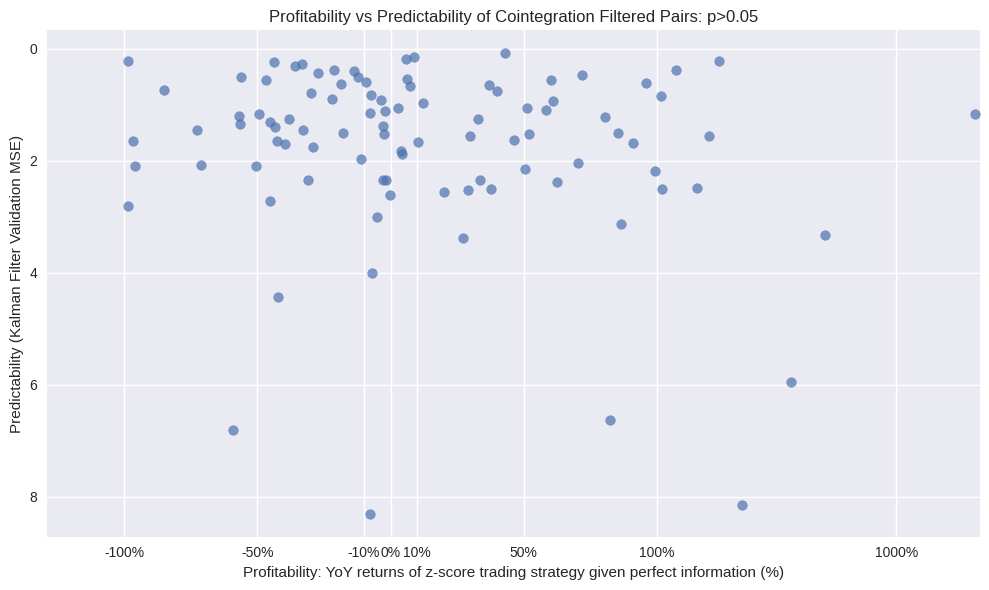

('(PRFZ,DVY)', 0.05931466778697958, 0.17298540878428892)
('(ACWI,PRFZ)', -0.568282903104933, 1.196255577488896)
('(IGIB,PRFZ)', 0.2914144280299429, 2.5193695886190395)
('(PRFZ,PEY)', 0.42987084413192034, 0.0804422050607228)
('(PRFZ,IGF)', -0.21114903121801853, 0.372013513333306)
('(FEX,PRFZ)', -0.4951655496892795, 1.1622945165943)


In [48]:
# plotting
import matplotlib.pyplot as plt

pair_names = [r[0] for r in results]
profitability = [r[1] * 100 for r in results]  # gt_yoy
predictability = [r[2] for r in results]  # val_mse
plt.figure(figsize=(10, 6))
plt.scatter(profitability, predictability, alpha=0.7)
plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")
plt.ylabel("Predictability (Kalman Filter Validation MSE)")
plt.title("Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05")
plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

# optional: annotate pairs
# for i, name in enumerate(pair_names):
#     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

plt.grid(True)
plt.tight_layout()
plt.show()

# most negative profitability
most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!
lowest_mse_pair = min(results, key=lambda x: x[2])
lowest_mse = min(predictability)
for result in results:
  ticker = result[0]
  if "PRFZ" in ticker:
    print(result)


In [52]:
### Next step: let's see how well Kalman Filter val MSE predicts the Transformer val MSE
results = {}

for i in tqdm(range(len(pairs_data_filtered)), desc = "Gathering val MSE for 4 models, for different pairs.."):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  pair_tup_str = f"({ticker_a},{ticker_b})"
  output_kalman_with_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True)
  output_kalman_without_TA = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=False)
  results[pair_tup_str] = {"kalman_with_TA": output_kalman_with_TA['val_mse'], "kalman_without_TA": output_kalman_without_TA['val_mse']} # , "transformer_with_TA": output_transformer_with_TA['val_mse'], "transformer_without_TA": output_transformer_without_TA['val_mse']}

# take top 10 lowest val MSE from kalman_with_TA and kalman_without_TA
top_10_pairs = sorted(results.items(), key=lambda x: x[1]['kalman_with_TA'])[:10]
top_10_pairs_without_TA = sorted(results.items(), key=lambda x: x[1]['kalman_without_TA'])[:10]

for pair in top_10_pairs:
  print(pair[0], pair[1]['kalman_with_TA'])

for pair in top_10_pairs_without_TA:
  print(pair[0], pair[1]['kalman_without_TA'])

Gathering val MSE for 4 models, for different pairs..:   0%|          | 0/95 [00:00<?, ?it/s]

(PRFZ,PEY) 0.0804422050607228
(PNQI,IJT) 0.14604948451304084
(PRFZ,DVY) 0.17298540878428892
(QTEC,SMH) 0.21804553856895176
(EMB,SMH) 0.22370948780442346
(IBB,BBH) 0.22741895900630588
(PNQI,IUSG) 0.2639247547315956
(PKW,PEY) 0.30129587441495387
(PRFZ,IGF) 0.372013513333306
(IGSB,SOXX) 0.3812311158482354
(USIG,IEI) 0.7305263799437893
(IGSB,BND) 0.7843194672871262
(IGIB,IEI) 0.8771139647110548
(IGSB,MBB) 0.8844023556803413
(PFF,IGSB) 0.9635982426067718
(SHV,BND) 0.9663687624291881
(PFF,IGIB) 1.0076652225552942
(SHV,MBB) 1.0222583809757966
(IFGL,IGSB) 1.0617724479655641
(IGIB,PID) 1.0851715531702588


In [64]:
top_pairs_both = top_10_pairs + top_10_pairs_without_TA

results_with_transformer = {}

# now, create a results_with_transformer dictionary that uses the top 20
for pair in tqdm(top_pairs_both, desc = "Gathering val MSE for transformer models, for different pairs.."):
  current_pair_str = pair[0]
  ticker_a, ticker_b = current_pair_str[1:-1].split(",")[0], current_pair_str[1:-1].split(",")[1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  output_transformer_with_TA = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=current_pair_str, add_technical_indicators=True, epochs=20)
  output_transformer_without_TA = execute_transformer_workflow(pairs_timeseries_df, verbose=False, pair_tup_str=current_pair_str, add_technical_indicators=False, epochs=20)
  val_mse_transformer_with_TA = output_transformer_with_TA['val_mse']
  val_mse_transformer_without_TA = output_transformer_without_TA['val_mse']
  results_with_transformer[current_pair_str] = {"kalman_with_TA": pair[1]['kalman_with_TA'], "kalman_without_TA": pair[1]['kalman_without_TA'], "transformer_with_TA": val_mse_transformer_with_TA, "transformer_without_TA": val_mse_transformer_without_TA}

results_with_transformer

Gathering val MSE for transformer models, for different pairs..:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.003787 | val MSE 0.045835
Epoch 020 | train MSE 0.003749 | val MSE 0.042364
Test MSE  : 0.194426
Epoch 010 | train MSE 0.005291 | val MSE 0.026434
Epoch 020 | train MSE 0.005670 | val MSE 0.021109
Test MSE  : 0.136230
Epoch 010 | train MSE 0.003315 | val MSE 0.022591
Epoch 020 | train MSE 0.002996 | val MSE 0.021006
Test MSE  : 0.905115
Epoch 010 | train MSE 0.003369 | val MSE 0.015243
Epoch 020 | train MSE 0.002655 | val MSE 0.006760
Test MSE  : 0.210662
Epoch 010 | train MSE 0.003761 | val MSE 0.047444
Epoch 020 | train MSE 0.003757 | val MSE 0.042537
Test MSE  : 0.163436
Epoch 010 | train MSE 0.005701 | val MSE 0.037377
Epoch 020 | train MSE 0.005819 | val MSE 0.023669
Test MSE  : 0.055491
Epoch 010 | train MSE 0.002798 | val MSE 0.039308
Epoch 020 | train MSE 0.002643 | val MSE 0.042727
Test MSE  : 2.442144
Epoch 010 | train MSE 0.005847 | val MSE 0.042991
Epoch 020 | train MSE 0.004775 | val MSE 0.017968
Test MSE  : 0.354323
Epoch 010 | train MSE 0.005323 |

{'(PRFZ,PEY)': {'kalman_with_TA': 0.0804422050607228,
  'kalman_without_TA': 1.8406249646631174,
  'transformer_with_TA': 0.042363652243064,
  'transformer_without_TA': 0.021108950416629132},
 '(PNQI,IJT)': {'kalman_with_TA': 0.14604948451304084,
  'kalman_without_TA': 1.484209751029227,
  'transformer_with_TA': 0.021005531916251548,
  'transformer_without_TA': 0.006759780602386365},
 '(PRFZ,DVY)': {'kalman_with_TA': 0.17298540878428892,
  'kalman_without_TA': 1.8057175336088593,
  'transformer_with_TA': 0.04253651201725006,
  'transformer_without_TA': 0.02366903409934961},
 '(QTEC,SMH)': {'kalman_with_TA': 0.21804553856895176,
  'kalman_without_TA': 2.13261955125368,
  'transformer_with_TA': 0.0427269975726421,
  'transformer_without_TA': 0.017967735417187214},
 '(EMB,SMH)': {'kalman_with_TA': 0.22370948780442346,
  'kalman_without_TA': 1.9959630004464188,
  'transformer_with_TA': 0.03182911815551611,
  'transformer_without_TA': 0.04312357994226309},
 '(IBB,BBH)': {'kalman_with_TA': 0

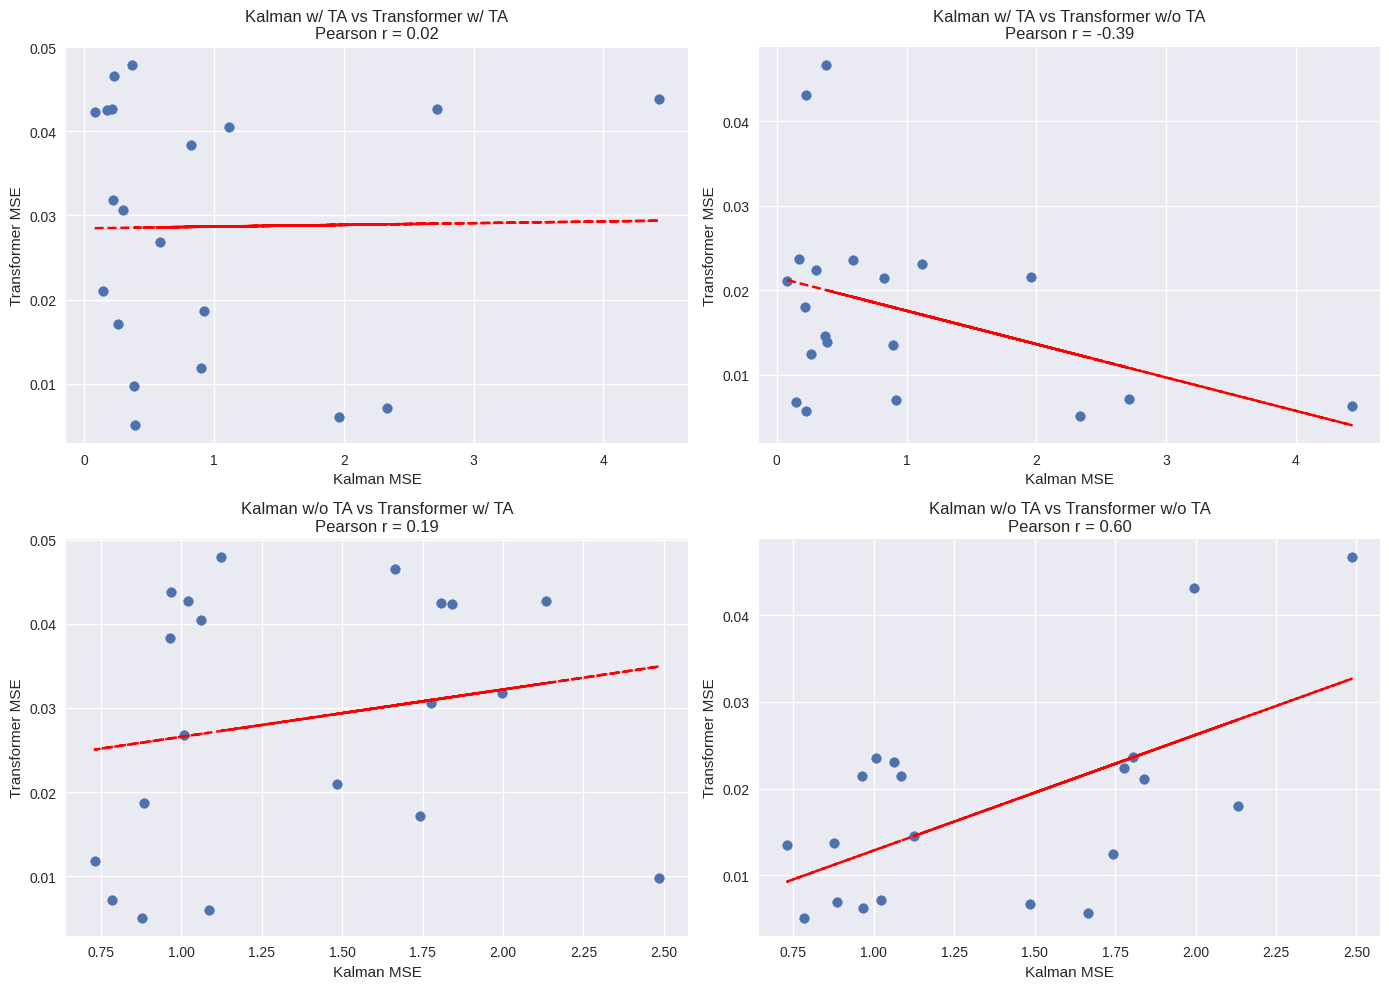

In [70]:
from scipy.stats import pearsonr

# Extract values
kalman_with = []
kalman_without = []
transformer_with = []
transformer_without = []

for k, d in results_with_transformer.items():
    kalman_with.append(d['kalman_with_TA'])
    kalman_without.append(d['kalman_without_TA'])
    transformer_with.append(d['transformer_with_TA'])
    transformer_without.append(d['transformer_without_TA'])

plot_info = [
    (kalman_with, transformer_with, "Kalman w/ TA vs Transformer w/ TA"),
    (kalman_with, transformer_without, "Kalman w/ TA vs Transformer w/o TA"),
    (kalman_without, transformer_with, "Kalman w/o TA vs Transformer w/ TA"),
    (kalman_without, transformer_without, "Kalman w/o TA vs Transformer w/o TA"),
]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (x, y, title) in enumerate(plot_info):
    axs[i].scatter(x, y)
    r, _ = pearsonr(x, y)
    axs[i].set_title(f"{title}\nPearson r = {r:.2f}")
    axs[i].set_xlabel("Kalman MSE")
    axs[i].set_ylabel("Transformer MSE")
    # Optional: add a best-fit line
    m, b = np.polyfit(x, y, 1)
    axs[i].plot(x, [m*xi + b for xi in x], color='red', linestyle='--')

plt.tight_layout()
plt.show()

#2. Create the caching for pairs data, AFTER doing cointegration tests


In [ ]:
# We want to not have to wait so long each time for finding the cointegration scores for pairs.

startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data)

# Note: this data was written here, and can also be found in `exp/gather_data.ipynb`.

In [72]:
import pickle

def save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIds, cache_dir='.'):
  base_filename = _get_filename(startDateStr, endDateStr, instrumentIds)
  filename_pairs_data = base_filename.replace(".pkl", "_pairs_data_filtered.pkl")
  filepath = os.path.join(cache_dir, filename_pairs_data)
  with open(filepath, 'wb') as f:
    pickle.dump(pairs_data_filtered, f)

def gather_pairs_data_cached(startDateStr, endDateStr, instrumentIds, cache_dir='.'):
  base_filename = _get_filename(startDateStr, endDateStr, instrumentIds)
  filename_pairs_data = base_filename.replace(".pkl", "_pairs_data_filtered.pkl")
  filepath = os.path.join(cache_dir, filename_pairs_data)
  if os.path.exists(filepath):
    with open(filepath, 'rb') as f:
      return pickle.load(f)
  else:
    return None

save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
pairs_data_from_cache = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
pairs_data_from_cache == pairs_data_filtered

True

In [73]:
pairs_data_from_cache

[(('PFF', 'IGSB'), 3.0163860840139413e-06),
 (('IGIB', 'IFGL'), 3.1322038155348414e-06),
 (('USIG', 'PPH'), 2.621351855041312e-05),
 (('USIG', 'PHO'), 0.0002540997299264048),
 (('IGIB', 'IGF'), 0.00037978034092713377),
 (('IGSB', 'EMB'), 0.0005964786506590314),
 (('IGIB', 'TLT'), 0.0007039730162819213),
 (('IFGL', 'IGSB'), 0.0007860628026761489),
 (('EMB', 'TLT'), 0.000824207180844204),
 (('SHV', 'PEY'), 0.0008390644259399934),
 (('EMB', 'SMH'), 0.0009269940276486267),
 (('IGSB', 'PEY'), 0.0009728025177510877),
 (('PFF', 'IGIB'), 0.0010572018262853824),
 (('IGIB', 'SMH'), 0.001142523000059977),
 (('IGIB', 'SOXX'), 0.0011449063816258095),
 (('IGSB', 'SHV'), 0.0012639632665603503),
 (('SHV', 'DVY'), 0.001275723390097672),
 (('IGSB', 'PPH'), 0.0013347040611567356),
 (('SHV', 'ONEQ'), 0.0014169289067739932),
 (('IGSB', 'DVY'), 0.0014398881633678018),
 (('EMB', 'ONEQ'), 0.0014626855085388669),
 (('SHV', 'PDP'), 0.0015738718296940393),
 (('IGSB', 'TLT'), 0.0016608503333871796),
 (('SHV', 'SM

#3. Create plots for all other pairs

Computing results for period: 2010-10-01_2024-10-02


Gathering val MSE and returns (2010-10-01_2024-10-02)..:   0%|          | 0/134 [00:00<?, ?it/s]

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[

lowest_mse_pair ('(IFGL,VONV)', -0.2990891710562491, 0.0866014256674186)


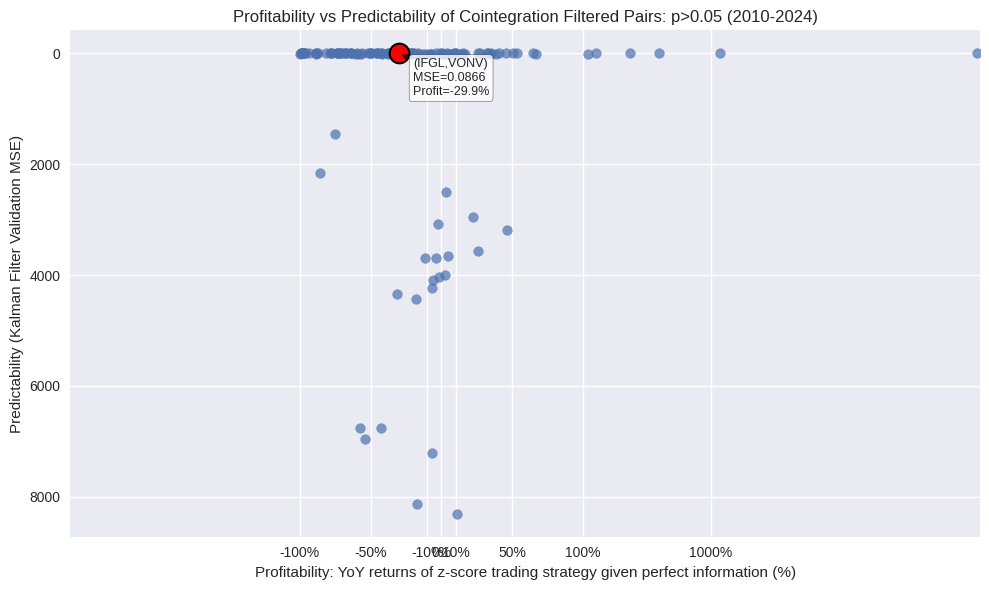

Computing results for period: 2008-10-01_2018-10-02


Gathering val MSE and returns (2008-10-01_2018-10-02)..:   0%|          | 0/95 [00:00<?, ?it/s]

lowest_mse_pair ('(PRFZ,PEY)', 0.42987084413192034, 0.0804422050607228)


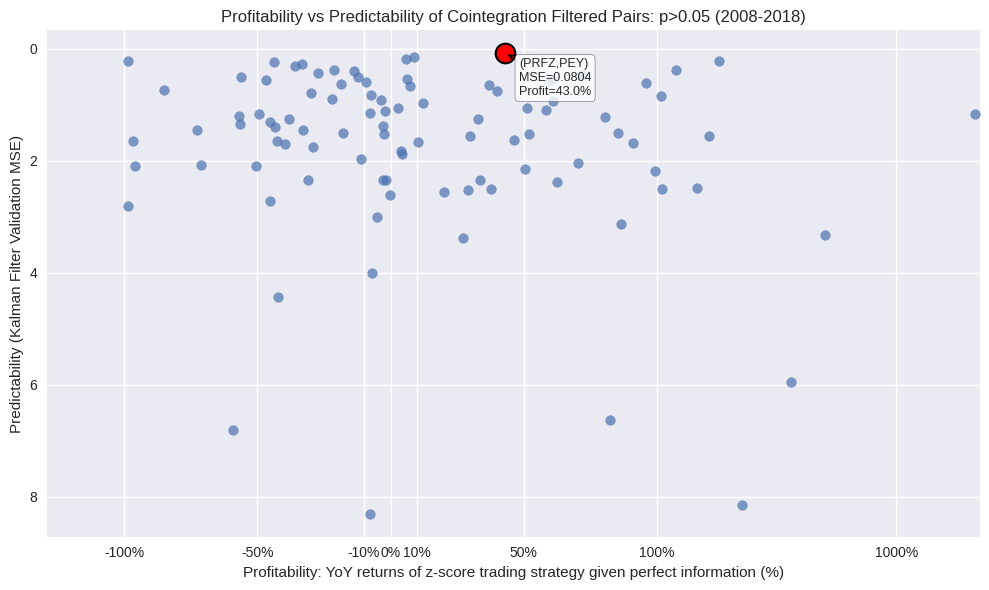

Computing results for period: 2007-01-01_2022-12-31


Gathering val MSE and returns (2007-01-01_2022-12-31)..:   0%|          | 0/5 [00:00<?, ?it/s]

/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]


lowest_mse_pair ('(SOXX,SMH)', nan, 0.28067181073802033)


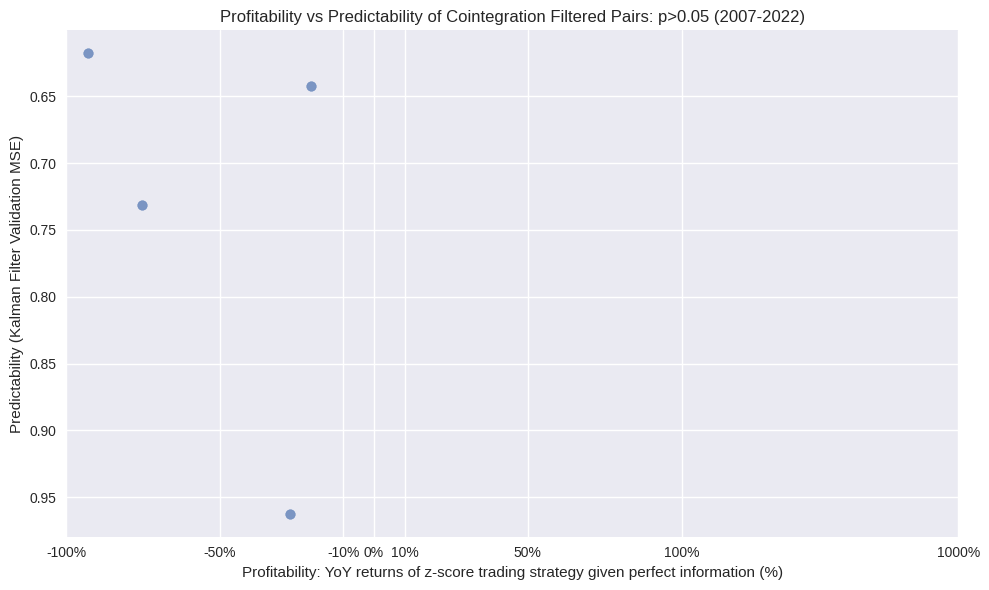

Computing results for period: 2007-01-01_2024-12-31


Gathering val MSE and returns (2007-01-01_2024-12-31)..:   0%|          | 0/8 [00:00<?, ?it/s]

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]


lowest_mse_pair ('(IUSG,ONEQ)', -0.8928629601180318, 0.23961070197318676)


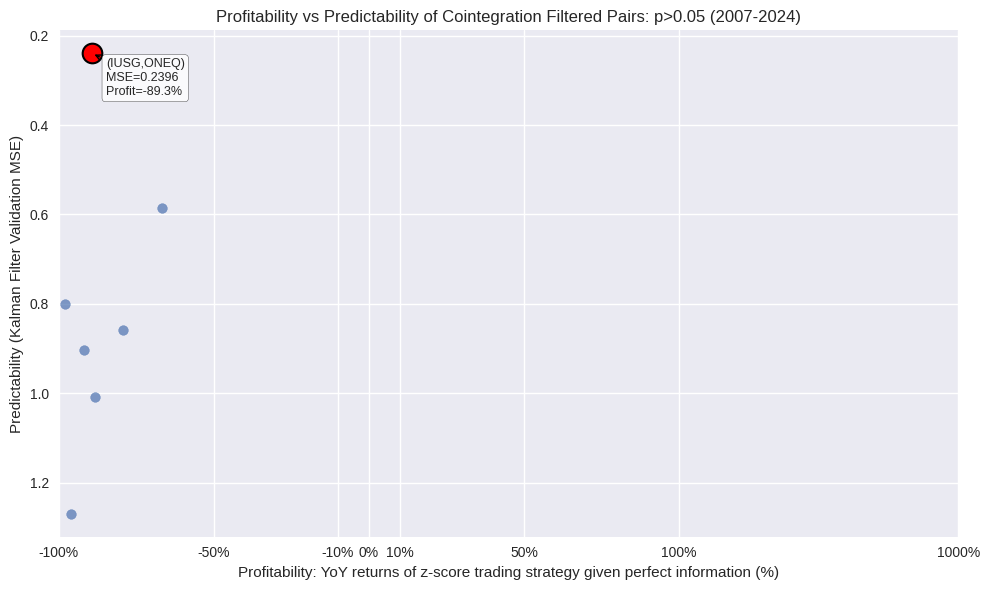

Computing results for period: 2007-01-01_2016-12-31


Gathering val MSE and returns (2007-01-01_2016-12-31)..:   0%|          | 0/1 [00:00<?, ?it/s]

lowest_mse_pair ('(PGJ,PEY)', -0.320757420656294, 0.9538881685226775)


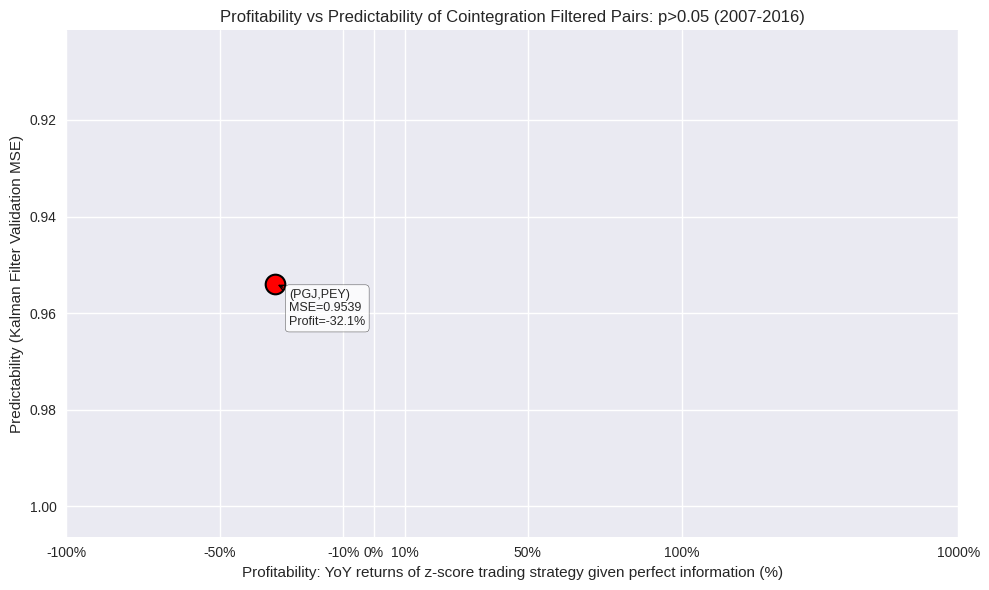

Computing results for period: 2007-01-01_2021-12-31


Gathering val MSE and returns (2007-01-01_2021-12-31)..:   0%|          | 0/7 [00:00<?, ?it/s]

/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))
/content/bsc-thesis/src/models/statistical_models.py:291: RuntimeWarning: invalid value encountered in power
  gt_yoy = ((gt_returns[-1] / gt_returns[0])**(365 / len(gt_returns)) - 1)[0]
/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


lowest_mse_pair ('(SOXX,SMH)', -0.9972741177681521, 0.17954550312327214)


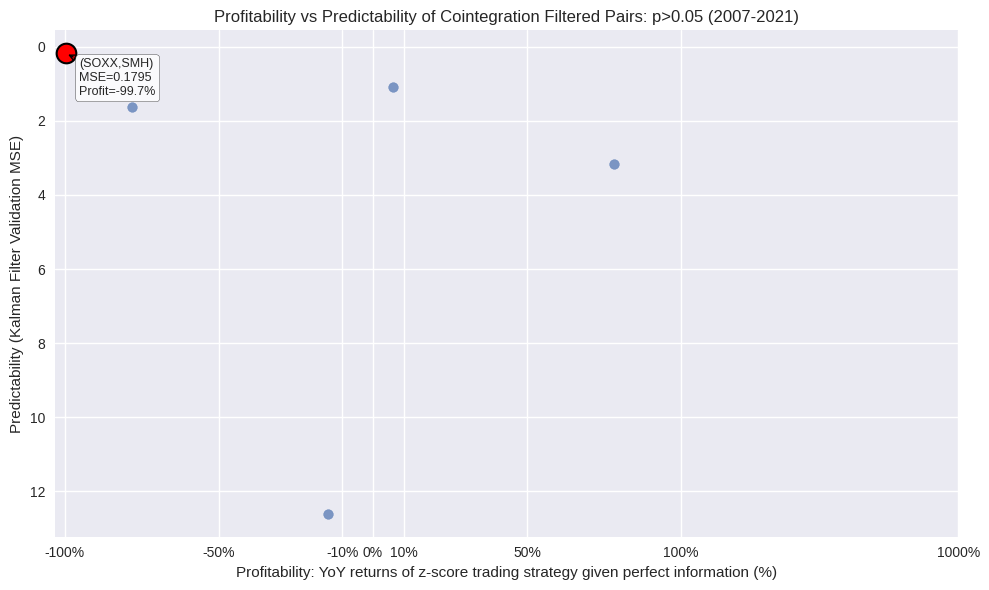

In [7]:
cached_results = {} # do this so we don't have to rerun the results each time in the notebook
# plotting
import matplotlib.pyplot as plt

def plot_predictability_profitability(startDateStr, endDateStr, train_frac_current, dev_frac_current):
  global cached_results
  period_key = f"{startDateStr}_{endDateStr}"

  if period_key in cached_results:
      print(f"Loaded cached results for period: {period_key}")
      results = cached_results[period_key]
  else:
      print(f"Computing results for period: {period_key}")
      instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
      data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
      data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
      data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

      pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

      results = []
      for i in tqdm(range(len(pairs_data_filtered)), desc = f"Gathering val MSE and returns ({period_key}).."):
          ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
          pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
          pair_tup_str = f"({ticker_a},{ticker_b})"
          output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True, train_frac=train_frac_current, dev_frac=dev_frac_current)
          results.append((pair_tup_str, output['gt_yoy'], output['val_mse']))

      # Cache results
      cached_results[period_key] = results

  pair_names = [r[0] for r in results]
  profitability = [r[1] * 100 for r in results]  # gt_yoy
  predictability = [r[2] for r in results]  # val_mse
  plt.figure(figsize=(10, 6))
  plt.scatter(profitability, predictability, alpha=0.7)
  plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")

  most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!
  lowest_mse_pair = min(results, key=lambda x: x[2])
  print("lowest_mse_pair", lowest_mse_pair)
  lowest_pair_name = lowest_mse_pair[0]
  lowest_pair_profitability = lowest_mse_pair[1] * 100
  lowest_pair_predictability = lowest_mse_pair[2]
  # Add big, special marker for lowest MSE pair
  plt.scatter([lowest_pair_profitability], [lowest_pair_predictability],
              color='red', s=200, edgecolors='black', linewidths=1.5)

  # Annotate the lowest MSE pair
  plt.annotate(f'{lowest_pair_name}\nMSE={lowest_pair_predictability:.4f}\nProfit={lowest_pair_profitability:.1f}%',
              (lowest_pair_profitability, lowest_pair_predictability),
              textcoords="offset points", xytext=(10, -30), ha='left',
              fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8),
              arrowprops=dict(arrowstyle="->", lw=1))

  plt.ylabel("Predictability (Kalman Filter Validation MSE)")
  startYear = startDateStr.split("-")[0]
  endYear = endDateStr.split("-")[0]
  plt.title(f"Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05 ({startYear}-{endYear})")
  plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
  plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
  plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

  # optional: annotate all pairs
  # for i, name in enumerate(pair_names):
  #     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

  plt.grid(True)
  plt.tight_layout()
  plt.show()


from datetime import datetime
def _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest, verbose=False):
  """
  For certain periods, we want a specific testing period, and must therefore calculate the train/dev split based on that.
  """
  # convert all 4 dates to datetime
  startDateStr = datetime.strptime(startDateStr, '%Y-%m-%d')
  endDateStr = datetime.strptime(endDateStr, '%Y-%m-%d')
  startDateStrTest = datetime.strptime(startDateStrTest, '%Y-%m-%d')
  endDateStrTest = datetime.strptime(endDateStrTest, '%Y-%m-%d')

  total_days = (endDateStr - startDateStr).days
  test_days = (endDateStrTest - startDateStrTest).days
  train_days = total_days - 2 * test_days

  train_frac = train_days / total_days
  test_frac = test_days / total_days
  dev_frac = test_frac

  if verbose:
    print(f"train_frac: {train_frac}")
    print(f"dev_frac: {dev_frac}")
    print(f"test_frac: {test_frac}")

  return train_frac, dev_frac

## PERIOD 1
startDateStr1 = '2010-10-01'
endDateStr1 = '2024-10-02'
train_frac1 = 0.90
dev_frac1 = 0.05

## PERIOD 2
startDateStr2 = '2008-10-01'
endDateStr2 = '2018-10-02'
train_frac2 = 0.90
dev_frac2 = 0.05

## PERIOD 3
startDateStr3 = '2007-01-01'
endDateStr3 = '2022-12-31'
# wanted test year: test 2022/01-2022/12
startDateStrTest3 = '2022-01-01'
endDateStrTest3 = '2022-12-31'
train_frac3, dev_frac3 = _get_train_dev_frac(startDateStr3, endDateStr3, startDateStrTest3, endDateStrTest3)

## PERIOD 4
startDateStr4 = '2007-01-01'
endDateStr4 = '2024-12-31'
# test 2024/01-2024/12
startDateStrTest4 = '2024-01-01'
endDateStrTest4 = '2024-12-31'
train_frac4, dev_frac4 = _get_train_dev_frac(startDateStr4, endDateStr4, startDateStrTest4, endDateStrTest4)

## PERIOD 5
startDateStr5 = '2007-01-01'
endDateStr5 = '2016-12-31'
# test 2014/07-2016
startDateStrTest5 = '2014-07-01'
endDateStrTest5 = '2016-12-31'
train_frac5, dev_frac5 = _get_train_dev_frac(startDateStr5, endDateStr5, startDateStrTest5, endDateStrTest5)

## PERIOD 6
startDateStr6 = '2007-01-01'
endDateStr6 = '2021-12-31'
# test 2020/01-2021/12
startDateStrTest6 = '2020-01-01'
endDateStrTest6 = '2021-12-31'
train_frac6, dev_frac6 = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

all_inputs = [
    (startDateStr1, endDateStr1, train_frac1, dev_frac1),
    (startDateStr2, endDateStr2, train_frac2, dev_frac2),
    (startDateStr3, endDateStr3, train_frac3, dev_frac3),
    (startDateStr4, endDateStr4, train_frac4, dev_frac4),
    (startDateStr5, endDateStr5, train_frac5, dev_frac5),
    (startDateStr6, endDateStr6, train_frac6, dev_frac6)
]

for startDateStr, endDateStr, train_frac, dev_frac in all_inputs:
  plot_predictability_profitability(startDateStr, endDateStr, train_frac, dev_frac)